# CS 181 Homework \#2
## Santiago Giner

## Problem 1
### Problem 1, Subpart 1

In [1]:
# loading data
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.stats import mode

# data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

In [2]:
# Basis functions
# phi_1(t) = [1, t]
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

# phi_2(t) = [1, t, t^2]
def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    t = np.array(t)
    res = np.stack([np.ones(len(t)), t, t**2], axis=1)
    assert res.shape == (len(t), 3), f"Error: shape of return array is not ({len(t)}, 3)"
    return res

# phi_3(t) = [1, t, t^2, t^3, t^4, t^5]
def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    return np.stack([np.ones(len(t))] + [t ** p for p in range(1, 6)], axis=1)

In [10]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (2 x 1), (3 x 1), or (6 x 1)
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        # TODO
        N = x.shape[0]
        for run in range(self.runs):
            # Compute gradient
            # Received help in OH to debug this function
            grad = np.dot((self.predict(x) - y).T, x).T / N
            self.W = self.W - self.eta * grad

    def predict(self, x):
        """
        Predict classification probability of transformed input x
        
        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        # TODO
        pred = sigmoid(np.dot(x, self.W))
        assert pred.shape == (x.shape[0], 1)
        return pred

### **Test Outcomes**

In [11]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Pass


### Problem 1, Subpart 2

In [12]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

In [13]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

    visualize_prediction_lines(x, y, all_models, basis, title)

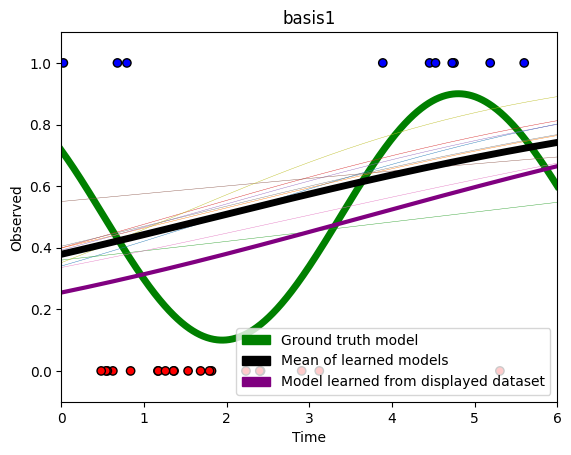

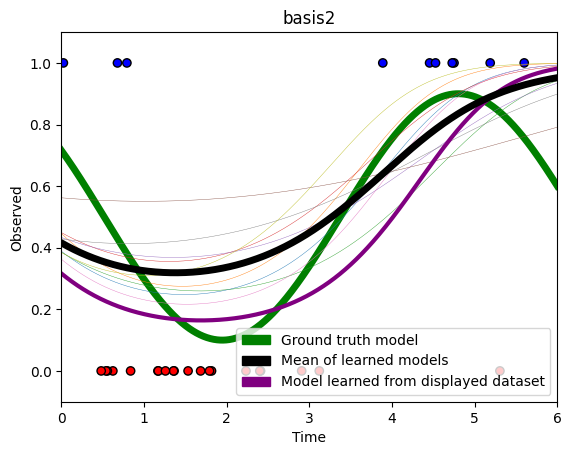

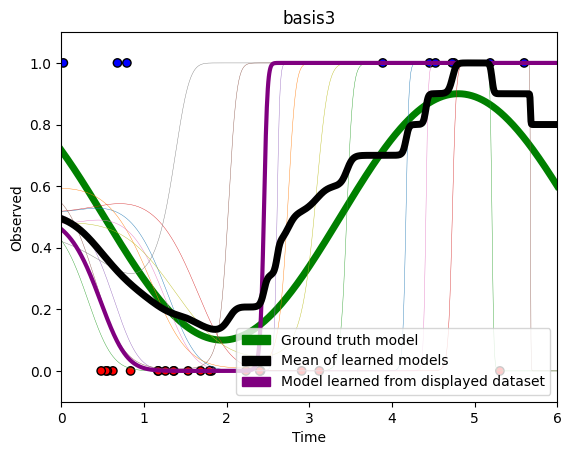

In [14]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

### Problem 1, Subpart 4

In [8]:
eta = 0.001
runs = 10000

t = 0.1
test_point = basis3(np.array([t]))

predictions = []
for i in range(10):
    x, y = t_obs[i], y_obs[i]
    x_transformed = basis3(x)
    model = LogisticRegressor(eta=eta, runs=runs)
    model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
    pred = model.predict(test_point)[0][0]
    if i == 0:
        print(f"Prediction of first model on t = 0.1: {pred}")
    predictions.append(pred)
print(f"Variance of the predictions at t = {t} is: {np.var(predictions)}")

Prediction of first model on t = 0.1: 0.5197126318279172
Variance of the predictions at t = 0.1 is: 0.0033595025822841284


In [9]:
eta = 0.001
runs = 10000

t = 3.2
test_point = basis3(np.array([t]))

predictions = []
for i in range(10):
    x, y = t_obs[i], y_obs[i]
    x_transformed = basis3(x)
    model = LogisticRegressor(eta=eta, runs=runs)
    model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
    pred = model.predict(test_point)[0][0]
    if i == 0:
        print(f"Prediction of first model on t = {t}: {pred}")
    predictions.append(pred)
print(f"Variance of the predictions at t = {t} is: {np.var(predictions)}")

Prediction of first model on t = 3.2: 1.3930894701224269e-08
Variance of the predictions at t = 3.2 is: 0.23094939529158362


## Problem 3
### Problem 3, Subpart 1

#### **Softmax Classifier**

In [114]:
# Function to create a one-hot vector from class value
def one_hot(class_val, num_classes):
    y = np.zeros(num_classes, dtype=int)
    y[class_val] = 1
    return y

# Softmax classifier with L_2 regularization
class SoftmaxRegression:
    def __init__(self, eta, lam):
        self.eta = eta
        self.lam = lam
        self.W = None
        self.runs = 200000

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        in the form (lambda/2) * norm(w)^2
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        # Add bias column to features X
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        # Initializing the weights (do not change!)
        # The number of classes is 1 + (the highest numbered class)
        num_classes = 1 + y.max()
        num_features = X.shape[1]
        self.W = np.ones((num_classes, num_features))
        # Convert y into array of one-hot vectors
        y = np.array([one_hot(y_n, num_classes) for y_n in y])
        # Iterate over each row of weights
        for run in range(self.runs):
            preds = self.predict_proba(X)
            for j in range(num_classes):
                # Compute gradient
                grad_wj = np.dot(preds[:, j] - y[:, j], X)
                # Add regularization term
                grad_wj += self.lam * self.W[j]
                # Update the row of weights
                self.W[j] -= self.eta * grad_wj


    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        pred = np.array([softmax(np.dot(self.W, x)).argmax() for x in X_pred])
        assert pred.shape == (X_pred.shape[0],)
        return pred
    
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        proba = np.array([softmax(np.dot(self.W, x)) for x in X_pred])
        assert proba.shape == (X_pred.shape[0], self.W.shape[0])
        return proba

#### **kNN Classifier**

In [115]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.k = k
        
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y
    
    # Define the distance function
    def distance(self, x1, x2):
        return (x1[0] - x2[0])**2 / 9 + (x1[1] - x2[1])**2

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        # TODO
        preds = []
        for x in X_pred:
            # Find distances to each point and select k nearest neighbors
            distances = [self.distance(x, x_data) for x_data in self.X]
            k_neighbors = self.y[np.argsort(distances)][:self.k]
            # Prediction is the mode of the classes of each of the k neighbors
            preds.append(mode(k_neighbors, keepdims=False).mode)
        return np.array(preds)
    
    # Function to give classification probability of data points
    def predict_proba(self, X_pred):
        probs = []
        for x in X_pred:
            # Find distances to each point and select k nearest neighbors
            distances = [self.distance(x, x_data) for x_data in self.X]
            k_neighbors = self.y[np.argsort(distances)][:self.k]
            # Prediction is the mode of the classes of each of the k neighbors
            probs.append(mode(k_neighbors, keepdims=False).count / self.k)
        return np.array(probs)

In [116]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    return np.array([[np.log(x[0] + 10), x[1]**2] for x in X])

In [118]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    
    if basis is not None:
        X_pred = basis(X_pred)
        
    # Add bias column to X_pred
    X_pred = np.hstack([np.ones((X_pred.shape[0], 1)), X_pred])

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

In [119]:
# Fit the softmax classifier without basis map phi(x)
start = time.time()
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
print(f"Fitting took: {time.time() - start:.2f} s")

Fitting took: 114.69 s


In [120]:
# Fit softmax classifier with basis
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)

In [121]:
print("Softmax (no basis) weight matrix:")
print(softmax_model.W)

Softmax (no basis) weight matrix:
[[ 12.15017629   3.47210612 -15.42828769]
 [  1.39298188   0.77670128   7.24822137]
 [-11.08696616  -1.79261539  10.63625833]]


In [122]:
print("Softmax (with basis) weight matrix:")
print(basis_model.W)

Softmax (with basis) weight matrix:
[[-8.92385352  7.42722582 -0.98134517]
 [-5.27856831  4.90931462  0.55637611]
 [16.65861384 -9.88034843  2.88116108]]


#### **Testing the classifiers...**

In [123]:
test_p3_softmax(softmax_model, basis_model)

Passed softmax regression tests


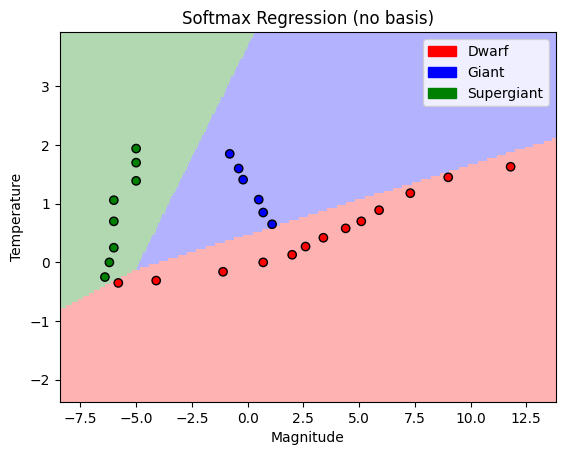

In [124]:
# Plot softmax without basis decision boundary
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='Softmax Regression (no basis)',
                   basis=None)

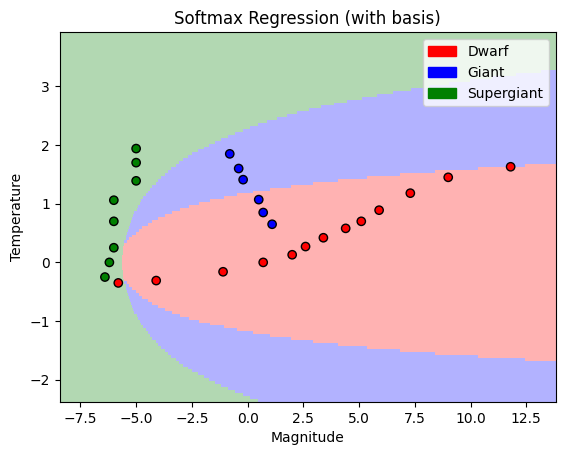

In [125]:
# Plot softmax with basis decision boundary
visualize_boundary(model=basis_model,
                   X=X_stars,
                   y=y_stars,
                   title='Softmax Regression (with basis)',
                   basis=phi)

In [126]:
# Visualize the decision boundary that a model produces
def visualize_boundary_kNN(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    
    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

In [127]:
# Initialize and git kNN classifiers for k = 1 and k = 5
knn1_model = KNNClassifier(1)
knn1_model.fit(X_stars, y_stars)
knn5_model = KNNClassifier(5)
knn5_model.fit(X_stars, y_stars)

In [128]:
# Test kNN classifiers
test_p3_knn(knn1_model, knn5_model)

Passed KNN tests


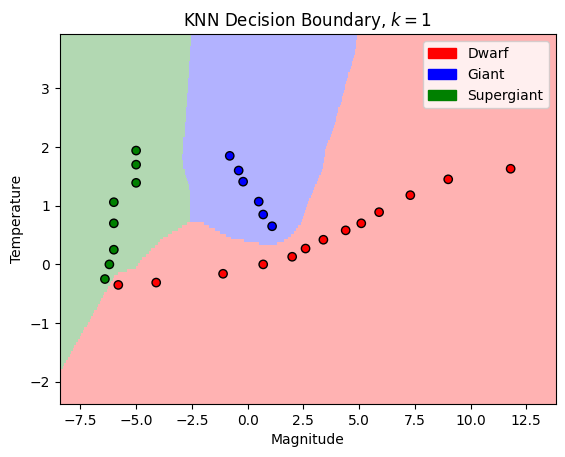

In [133]:
# Plot kNN with k = 1 decision boundary
visualize_boundary_kNN(model=knn1_model,
                   X=X_stars,
                   y=y_stars,
                   title="KNN Decision Boundary, $k = 1$",
                   basis=None)

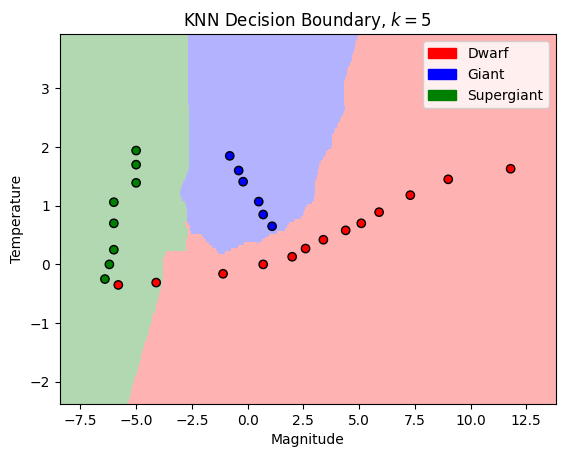

In [134]:
# Plot kNN with k = 5 decision boundary
visualize_boundary_kNN(model=knn5_model,
                   X=X_stars,
                   y=y_stars,
                   title="KNN Decision Boundary, $k = 5$",
                   basis=None)

### Problem 3, Subpart 2

In [135]:
test_point = np.array([[1, 3, -2]])
# Two softmax predictions
pred_a, p_a = softmax_model.predict(test_point)[0], softmax_model.predict_proba(test_point)[0]
pred_b, p_b = basis_model.predict(test_point)[0], basis_model.predict_proba(test_point)[0]

# Two kNN predictions
pred_c, p_c = knn1_model.predict(test_point)[0], knn1_model.predict_proba(test_point)[0]
pred_d, p_d = knn5_model.predict(test_point)[0], knn5_model.predict_proba(test_point)[0]

# Print predictions
print(f"Softmax (no basis) prediction: {pred_a}, with probability {p_a[pred_a]}")
print(f"Softmax (with basis) prediction: {pred_b}, with probability {p_b[pred_b]}")
print(f"kNN, k = 1 prediction: {pred_c}, with probability {p_c}")
print(f"kNN, k = 5 prediction: {pred_d}, with probability {p_d}")

Softmax (no basis) prediction: 0, with probability 1.0
Softmax (with basis) prediction: 0, with probability 0.9990741674934283
kNN, k = 1 prediction: 1, with probability 1.0
kNN, k = 5 prediction: 1, with probability 1.0


## Problem 4
### Problem 4, Subpart 1

In [138]:
# Fitted weight vector
w = np.array([0.2, 0.8, -0.012, 0.45, 0.001, -0.007])
age, sex, height, bp = 50, 0, 168, 140

# Patient data
drug = np.array([1, 1, age, sex, height, bp])
no_drug = np.array([1, 0, age, sex, height, bp])

p_drug, p_nodrug = sigmoid(np.dot(w, drug)), sigmoid(np.dot(w, no_drug))
print(f"Prob. with drug: {p_drug:.4f}, without drug: {p_nodrug:.4f}")
print(f"Probability difference: {p_drug - p_nodrug:.4f}")

Prob. with drug: 0.3984, without drug: 0.2293
Probability difference: 0.1691
